In [3]:
!pip install EfficientNet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.4 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from efficientnet.tfkeras import EfficientNetB3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.applications import ResNet50
from keras.applications import MobileNetV2
from keras.applications import NASNetMobile
from keras.applications import VGG19
from keras.applications import EfficientNetV2S
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model


#Load Dataset

In [ ]:
batikTrain = "/content/drive/MyDrive/DATASETmin/DATASETmin/TRAIN"
batikVal = "/content/drive/MyDrive/DATASETmin/DATASETmin/TEST"

# EDA

## Checking Format & total images in all directory

In [ ]:
import imghdr

def count_images_and_formats(directory):
    formats = {}
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            file_extension = os.path.splitext(file)[1].lower()
            if file_extension in formats:
                formats[file_extension] += 1
            else:
                formats[file_extension] = 1
    total_images = sum(formats.values())
    return total_images, formats

# Count the number of images and their formats
train_image_count, train_formats = count_images_and_formats(batikTrain)
val_image_count, val_formats = count_images_and_formats(batikVal)

# Display the total number of images and their formats
print("Total number of training images: ", train_image_count)
print("Training image formats: ", train_formats)
print("Total number of testing images: ", val_image_count)
print("Testing image formats: ", val_formats)

Total number of training images:  700
Training image formats:  {'.jpg': 700}
Total number of testing images:  200
Testing image formats:  {'.jpg': 200}


## Distribution of images in Training and validation sets

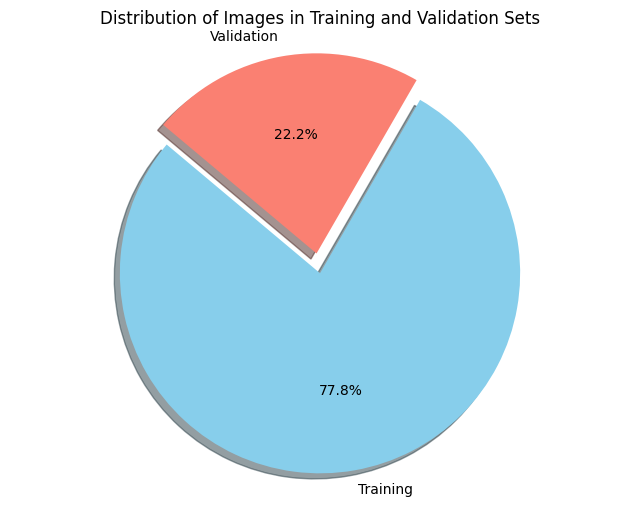

In [ ]:
import matplotlib.pyplot as plt

# Total number of images in training and validation sets
total_train_images = train_image_count
total_val_images = val_image_count

# Calculate percentages
train_percent = (total_train_images / (total_train_images + total_val_images)) * 100
val_percent = (total_val_images / (total_train_images + total_val_images)) * 100

# Plotting
labels = ['Training', 'Validation']
sizes = [train_percent, val_percent]
colors = ['skyblue', 'salmon']
explode = (0.1, 0)

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of Images in Training and Validation Sets')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## Total number of images in Validation Class

In [ ]:
def count_images_in_each_class(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len([file for file in os.listdir(class_path) if file.endswith(('.jpg', '.jpeg', '.png'))])
    return class_counts

# Directory to be analyzed
directory = batikVal

# Count the number of images in each class
class_counts = count_images_in_each_class(directory)

# Display the number of images in each class
print('List Of All Class :')
for class_name, count in class_counts.items():
    print('===================')
    print(f"'{class_name}': {count}")

List Of All Class :
'Batik Sekar Jagad': 20
'Batik Tambal': 20
'Batik Insang': 20
'Batik Ikat Celup': 20
'Batik Parang': 20
'Batik Megamendung': 20
'Batik Poleng': 20
'Batik Kawung': 20
'Batik Cendrawasih': 20
'Batik Dayak': 20


## Total Images In Training Class

In [ ]:
def count_images_in_each_class(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len([file for file in os.listdir(class_path) if file.endswith(('.jpg', '.jpeg', '.png'))])
    return class_counts

# Directory to be analyzed
directory = batikTrain

# Count the number of images in each class
class_counts = count_images_in_each_class(directory)

# Display the number of images in each class
print('List Of All Class :')
for class_name, count in class_counts.items():
    print('===================')
    print(f"'{class_name}': {count}")

List Of All Class :
'Batik Tambal': 70
'Batik Sekar Jagad': 70
'Batik Megamendung': 70
'Batik Parang': 70
'Batik Poleng': 70
'Batik Ikat Celup': 70
'Batik Insang': 70
'Batik Kawung': 70
'Batik Cendrawasih': 70
'Batik Dayak': 70


# Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

#Train
train_gen = train_datagen.flow_from_directory(
                                            batikTrain,
                                                    target_size=(300, 300),
                                                    batch_size=32,
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                            )

#Validation
val_gen = val_datagen.flow_from_directory(
                                            batikVal,
                                                    target_size=(300,300),
                                                    batch_size=32,
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                )


Found 700 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


In [ ]:
#Test
test_gen = val_datagen.flow_from_directory(
                                            batikVal,
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                )


Found 200 images belonging to 10 classes.


# CheckPointCallBack

In [ ]:
checkpoint_callback = ModelCheckpoint(
    filepath='BatikMotifMin_10_model_EfficientNetV2S_epoch_{epoch:02d}.h5',
    save_weights_only=False,
    save_freq='epoch',
    verbose=1
)

# EfficientNetB3 model

In [ ]:
pre_train_EfficientNetB3 = EfficientNetB3(
    input_shape=(300, 300, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)

44107200/44107200 [==============================] - 1s 0us/step


In [ ]:
pre_train_EfficientNetB3.trainable = False

In [ ]:
model_ENB3 = tf.keras.Sequential([
    pre_train_EfficientNetB3,
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='softmax')
])

Building model with <keras.src.engine.functional.Functional object at 0x7d4771342140>


In [ ]:
model_ENB3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epoch = 60
verb = 1

history = model_ENB3.fit(
            train_gen ,
            validation_data = val_gen,
            epochs = epoch,
            verbose = verb,
            callbacks=[checkpoint_callback])

Epoch 1/60
22/22 [==============================] - ETA: 0s - loss: 2.2528 - accuracy: 0.1671 
Epoch 1: saving model to BatikMotifMin_10_EfficientNetB3_epoch_01.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 653s 30s/step - loss: 2.2528 - accuracy: 0.1671 - val_loss: 1.9991 - val_accuracy: 0.4200
Epoch 2/60
22/22 [==============================] - ETA: 0s - loss: 1.8835 - accuracy: 0.4086
Epoch 2: saving model to BatikMotifMin_10_EfficientNetB3_epoch_02.h5
22/22 [==============================] - 25s 1s/step - loss: 1.8835 - accuracy: 0.4086 - val_loss: 1.6835 - val_accuracy: 0.6000
Epoch 3/60
22/22 [==============================] - ETA: 0s - loss: 1.6054 - accuracy: 0.5614
Epoch 3: saving model to BatikMotifMin_10_EfficientNetB3_epoch_03.h5
22/22 [==============================] - 24s 1s/step - loss: 1.6054 - accuracy: 0.5614 - val_loss: 1.4347 - val_accuracy: 0.6500
Epoch 4/60
22/22 [==============================] - ETA: 0s - loss: 1.3566 - accuracy: 0.6229
Epoch 4: saving model to BatikMotifMin_10_EfficientNetB3_epoch_04.h5
22/22 [==============================] - 24s 1s/step - loss: 1.3566 - accuracy: 0.6229 - val_loss: 1.2512 - val_accuracy: 

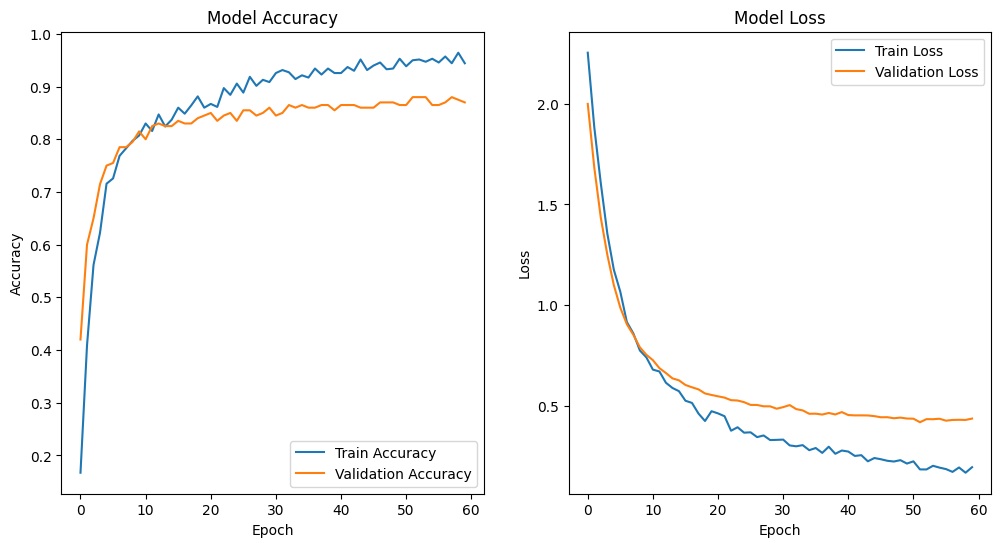

In [ ]:
def plot_metrics(history):

    plt.figure(figsize=(12, 6))


    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()


    plt.show()


plot_metrics(history)

## Classification Report Model

In [ ]:
class_names = list(val_gen.class_indices.keys())

y_test = []
y_pred = []

for i in range(len(val_gen)):
    x_batch, y_batch = val_gen.next()

    for j in range(len(y_batch)):

        y_test.append(class_names[tf.argmax(y_batch[j]).numpy()])

        prediction = model_ENB3.predict(x_batch[j][None, ...], verbose=0)
        y_pred.append(class_names[np.argmax(prediction)])


print(classification_report(y_test, y_pred, target_names=class_names))

                   precision    recall  f1-score   support

Batik Cendrawasih       0.80      0.80      0.80        20
      Batik Dayak       0.69      0.90      0.78        20
 Batik Ikat Celup       1.00      0.85      0.92        20
     Batik Insang       0.86      0.95      0.90        20
     Batik Kawung       0.88      0.75      0.81        20
Batik Megamendung       1.00      0.85      0.92        20
     Batik Parang       1.00      0.95      0.97        20
     Batik Poleng       0.84      0.80      0.82        20
Batik Sekar Jagad       0.83      0.95      0.88        20
     Batik Tambal       0.90      0.90      0.90        20

         accuracy                           0.87       200
        macro avg       0.88      0.87      0.87       200
     weighted avg       0.88      0.87      0.87       200



## Best Classification EfficientNet B3

In [ ]:
model_ENB3_BEST = load_model('/content/BatikMotifMin_10_EfficientNetB3_epoch_54.h5')

In [ ]:
class_names = list(val_gen.class_indices.keys())

y_test = []
y_pred = []
model_names = model_ENB3_BEST
for i in range(len(val_gen)):
    x_batch, y_batch = val_gen.next()

    for j in range(len(y_batch)):

        y_test.append(class_names[tf.argmax(y_batch[j]).numpy()])

        prediction = model_names.predict(x_batch[j][None, ...], verbose=0)
        y_pred.append(class_names[np.argmax(prediction)])


print(classification_report(y_test, y_pred, target_names=class_names))

                   precision    recall  f1-score   support

Batik Cendrawasih       0.80      0.80      0.80        20
      Batik Dayak       0.69      0.90      0.78        20
 Batik Ikat Celup       0.95      0.90      0.92        20
     Batik Insang       0.95      0.90      0.92        20
     Batik Kawung       0.89      0.80      0.84        20
Batik Megamendung       1.00      0.85      0.92        20
     Batik Parang       1.00      0.95      0.97        20
     Batik Poleng       0.85      0.85      0.85        20
Batik Sekar Jagad       0.83      0.95      0.88        20
     Batik Tambal       0.95      0.90      0.92        20

         accuracy                           0.88       200
        macro avg       0.89      0.88      0.88       200
     weighted avg       0.89      0.88      0.88       200



# MobileNet2 model

In [ ]:
pre_train_MobileNetV2 = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)

In [ ]:
pre_train_MobileNetV2.trainable = False

In [ ]:
model_MNETV2 = tf.keras.Sequential([
    pre_train_MobileNetV2,
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='softmax')
])


In [ ]:
model_MNETV2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epoch = 60
verb = 1

history_MNETV2 = model_MNETV2.fit(
            train_gen,
            validation_data = val_gen,
            epochs = epoch,
            verbose = verb,
            callbacks=[checkpoint_callback])

Epoch 1/60
22/22 [==============================] - ETA: 0s - loss: 2.8478 - accuracy: 0.2000 
Epoch 1: saving model to BatikMotifMin_10_model_MNETV2_epoch_01.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 486s 22s/step - loss: 2.8478 - accuracy: 0.2000 - val_loss: 1.8399 - val_accuracy: 0.3800
Epoch 2/60
22/22 [==============================] - ETA: 0s - loss: 1.7257 - accuracy: 0.4400
Epoch 2: saving model to BatikMotifMin_10_model_MNETV2_epoch_02.h5
22/22 [==============================] - 118s 5s/step - loss: 1.7257 - accuracy: 0.4400 - val_loss: 1.3843 - val_accuracy: 0.5850
Epoch 3/60
22/22 [==============================] - ETA: 0s - loss: 1.2315 - accuracy: 0.5871
Epoch 3: saving model to BatikMotifMin_10_model_MNETV2_epoch_03.h5
22/22 [==============================] - 96s 4s/step - loss: 1.2315 - accuracy: 0.5871 - val_loss: 1.1176 - val_accuracy: 0.6850
Epoch 4/60
22/22 [==============================] - ETA: 0s - loss: 0.9470 - accuracy: 0.6971
Epoch 4: saving model to BatikMotifMin_10_model_MNETV2_epoch_04.h5
22/22 [==============================] - 92s 4s/step - loss: 0.9470 - accuracy: 0.6971 - val_loss: 0.9470 - val_accuracy: 0.720

Exception ignored in: <function _xla_gc_callback at 0x7d478dcacf70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


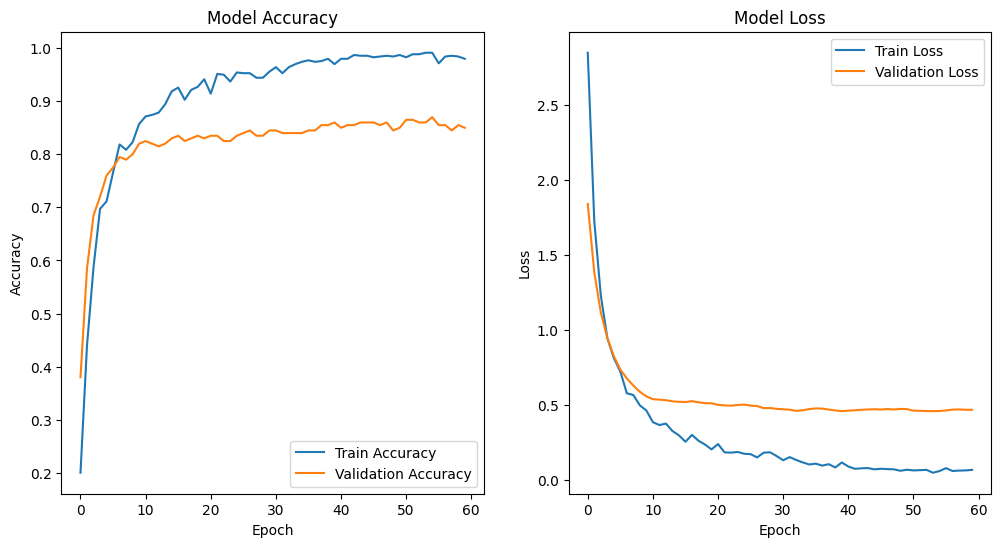

In [ ]:
def plot_metrics(history_MNETV2):

    plt.figure(figsize=(12, 6))


    plt.subplot(1, 2, 1)
    plt.plot(history_MNETV2.history['accuracy'], label='Train Accuracy')
    plt.plot(history_MNETV2.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_MNETV2.history['loss'], label='Train Loss')
    plt.plot(history_MNETV2.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()


    plt.show()


plot_metrics(history_MNETV2)

## Classification Report MobilenetV2

In [ ]:
class_names = list(val_gen.class_indices.keys())

y_test = []
y_pred = []
model_names = model_MNETV2
for i in range(len(test_gen)):
    x_batch, y_batch = test_gen.next()

    for j in range(len(y_batch)):

        y_test.append(class_names[tf.argmax(y_batch[j]).numpy()])

        prediction = model_names.predict(x_batch[j][None, ...], verbose=0)
        y_pred.append(class_names[np.argmax(prediction)])


print(classification_report(y_test, y_pred, target_names=class_names))

                   precision    recall  f1-score   support

Batik Cendrawasih       0.88      0.75      0.81        20
      Batik Dayak       0.75      0.75      0.75        20
 Batik Ikat Celup       0.83      0.75      0.79        20
     Batik Insang       0.90      0.95      0.93        20
     Batik Kawung       0.72      0.90      0.80        20
Batik Megamendung       1.00      0.90      0.95        20
     Batik Parang       1.00      0.85      0.92        20
     Batik Poleng       1.00      0.85      0.92        20
Batik Sekar Jagad       0.80      0.80      0.80        20
     Batik Tambal       0.63      0.85      0.72        20

         accuracy                           0.83       200
        macro avg       0.85      0.83      0.84       200
     weighted avg       0.85      0.83      0.84       200



## Classification Report Best Model MobilenetV2

In [ ]:
model_MNETV2_BEST = load_model('/content/BatikMotifMin_10_model_MNETV2_epoch_55.h5')

In [ ]:
class_names = list(val_gen.class_indices.keys())

y_test = []
y_pred = []
model_names = model_MNETV2_BEST
for i in range(len(test_gen)):
    x_batch, y_batch = test_gen.next()

    for j in range(len(y_batch)):

        y_test.append(class_names[tf.argmax(y_batch[j]).numpy()])

        prediction = model_names.predict(x_batch[j][None, ...], verbose=0)
        y_pred.append(class_names[np.argmax(prediction)])


print(classification_report(y_test, y_pred, target_names=class_names))

                   precision    recall  f1-score   support

Batik Cendrawasih       0.83      0.75      0.79        20
      Batik Dayak       0.71      0.75      0.73        20
 Batik Ikat Celup       0.80      0.80      0.80        20
     Batik Insang       0.90      0.90      0.90        20
     Batik Kawung       0.72      0.90      0.80        20
Batik Megamendung       1.00      0.90      0.95        20
     Batik Parang       1.00      0.80      0.89        20
     Batik Poleng       0.95      0.90      0.92        20
Batik Sekar Jagad       0.80      0.80      0.80        20
     Batik Tambal       0.70      0.80      0.74        20

         accuracy                           0.83       200
        macro avg       0.84      0.83      0.83       200
     weighted avg       0.84      0.83      0.83       200



# NASNetMobile model

In [ ]:
pre_train_NASNetMobile = NASNetMobile(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)

19993432/19993432 [==============================] - 1s 0us/step


In [ ]:
pre_train_NASNetMobile.trainable = False

In [ ]:
model_NASNetMobile = tf.keras.Sequential([
    pre_train_NASNetMobile,
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='softmax')
])


In [ ]:
model_NASNetMobile.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epoch = 90
verb = 1

history_NASNetMobile = model_NASNetMobile.fit(
            train_gen,
            validation_data = val_gen,
            epochs = epoch,
            verbose = verb,
            callbacks=[checkpoint_callback])

Epoch 1/60
22/22 [==============================] - ETA: 0s - loss: 2.9219 - accuracy: 0.1886
Epoch 1: saving model to BatikMotifMin_10_model_NASNetMobile_epoch_01.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 97s 4s/step - loss: 2.9219 - accuracy: 0.1886 - val_loss: 1.9722 - val_accuracy: 0.3300
Epoch 2/60
22/22 [==============================] - ETA: 0s - loss: 1.7587 - accuracy: 0.4214
Epoch 2: saving model to BatikMotifMin_10_model_NASNetMobile_epoch_02.h5
22/22 [==============================] - 93s 4s/step - loss: 1.7587 - accuracy: 0.4214 - val_loss: 1.5196 - val_accuracy: 0.5100
Epoch 3/60
22/22 [==============================] - ETA: 0s - loss: 1.1854 - accuracy: 0.5929
Epoch 3: saving model to BatikMotifMin_10_model_NASNetMobile_epoch_03.h5
22/22 [==============================] - 88s 4s/step - loss: 1.1854 - accuracy: 0.5929 - val_loss: 1.2111 - val_accuracy: 0.6600
Epoch 4/60
22/22 [==============================] - ETA: 0s - loss: 0.9696 - accuracy: 0.6771
Epoch 4: saving model to BatikMotifMin_10_model_NASNetMobile_epoch_04.h5
22/22 [==============================] - 92s 4s/step - loss: 0.9696 - accuracy: 0.6771 - val_loss: 1.0153 - val_

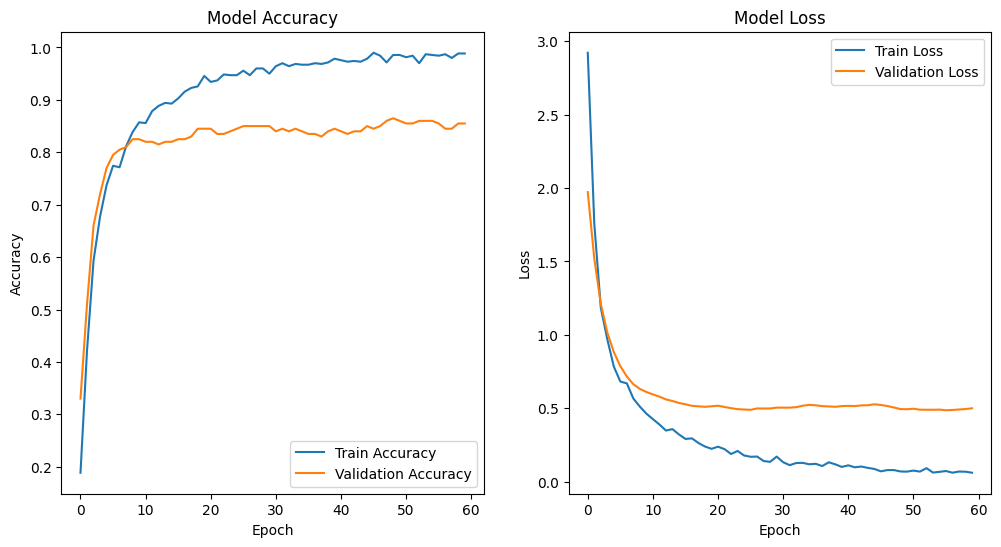

In [ ]:
def plot_metrics(history_NASNetMobile):

    plt.figure(figsize=(12, 6))


    plt.subplot(1, 2, 1)
    plt.plot(history_NASNetMobile.history['accuracy'], label='Train Accuracy')
    plt.plot(history_NASNetMobile.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_NASNetMobile.history['loss'], label='Train Loss')
    plt.plot(history_NASNetMobile.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()


    plt.show()


plot_metrics(history_NASNetMobile)

## Classification Report NASNetMobile

In [ ]:
class_names = list(val_gen.class_indices.keys())

y_test = []
y_pred = []
model_names = model_NASNetMobile
for i in range(len(test_gen)):
    x_batch, y_batch = test_gen.next()

    for j in range(len(y_batch)):

        y_test.append(class_names[tf.argmax(y_batch[j]).numpy()])

        prediction = model_names.predict(x_batch[j][None, ...], verbose=0)
        y_pred.append(class_names[np.argmax(prediction)])


print(classification_report(y_test, y_pred, target_names=class_names))

                   precision    recall  f1-score   support

Batik Cendrawasih       0.86      0.57      0.69        21
      Batik Dayak       0.62      0.75      0.68        20
 Batik Ikat Celup       0.67      0.75      0.71        16
     Batik Insang       1.00      0.75      0.86        20
     Batik Kawung       0.75      0.90      0.82        20
Batik Megamendung       1.00      0.81      0.89        21
     Batik Parang       1.00      0.90      0.95        21
     Batik Poleng       0.80      1.00      0.89        24
Batik Sekar Jagad       0.47      0.57      0.52        14
     Batik Tambal       0.77      0.74      0.76        23

         accuracy                           0.79       200
        macro avg       0.79      0.77      0.78       200
     weighted avg       0.81      0.79      0.79       200



## Classification Report Best Model NASNetMobile

In [ ]:
model_NASNetMobile_BEST = load_model('/content/BatikMotifMin_10_model_NASNetMobile_epoch_49.h5')

In [ ]:
class_names = list(val_gen.class_indices.keys())

y_test = []
y_pred = []
model_names = model_NASNetMobile_BEST
for i in range(len(test_gen)):
    x_batch, y_batch = test_gen.next()

    for j in range(len(y_batch)):

        y_test.append(class_names[tf.argmax(y_batch[j]).numpy()])

        prediction = model_names.predict(x_batch[j][None, ...], verbose=0)
        y_pred.append(class_names[np.argmax(prediction)])


print(classification_report(y_test, y_pred, target_names=class_names))

                   precision    recall  f1-score   support

Batik Cendrawasih       0.94      0.83      0.88        18
      Batik Dayak       0.62      0.80      0.70        20
 Batik Ikat Celup       0.69      0.82      0.75        22
     Batik Insang       1.00      0.67      0.80        21
     Batik Kawung       0.77      0.94      0.85        18
Batik Megamendung       1.00      0.83      0.91        18
     Batik Parang       0.90      0.76      0.83        25
     Batik Poleng       0.78      0.95      0.86        22
Batik Sekar Jagad       0.67      0.56      0.61        18
     Batik Tambal       0.72      0.72      0.72        18

         accuracy                           0.79       200
        macro avg       0.81      0.79      0.79       200
     weighted avg       0.81      0.79      0.79       200



# EfficientNetV2S model

In [ ]:
pre_train_EfficientNetV2S = EfficientNetV2S(
    input_shape=(300, 300, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)

82420632/82420632 [==============================] - 3s 0us/step


In [ ]:
pre_train_EfficientNetV2S.trainable = False

In [ ]:
model_EfficientNetV2S = tf.keras.Sequential([
    pre_train_EfficientNetV2S,
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='softmax')
])


In [ ]:
model_EfficientNetV2S.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epoch = 60
verb = 1

history_EfficientNetV2S = model_EfficientNetV2S.fit(
            train_gen,
            validation_data = val_gen,
            epochs = epoch,
            verbose = verb,
            callbacks=[checkpoint_callback])

Epoch 1/60
22/22 [==============================] - ETA: 0s - loss: 2.2834 - accuracy: 0.1457 
Epoch 1: saving model to BatikMotifMin_10_model_EfficientNetV2S_epoch_01.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 363s 16s/step - loss: 2.2834 - accuracy: 0.1457 - val_loss: 2.2186 - val_accuracy: 0.2450
Epoch 2/60
22/22 [==============================] - ETA: 0s - loss: 2.2152 - accuracy: 0.2086 
Epoch 2: saving model to BatikMotifMin_10_model_EfficientNetV2S_epoch_02.h5
22/22 [==============================] - 329s 15s/step - loss: 2.2152 - accuracy: 0.2086 - val_loss: 2.1639 - val_accuracy: 0.2150
Epoch 3/60
22/22 [==============================] - ETA: 0s - loss: 2.1853 - accuracy: 0.2429 
Epoch 3: saving model to BatikMotifMin_10_model_EfficientNetV2S_epoch_03.h5
22/22 [==============================] - 345s 16s/step - loss: 2.1853 - accuracy: 0.2429 - val_loss: 2.1155 - val_accuracy: 0.2650
Epoch 4/60
22/22 [==============================] - ETA: 0s - loss: 2.1570 - accuracy: 0.2229 
Epoch 4: saving model to BatikMotifMin_10_model_EfficientNetV2S_epoch_04.h5
22/22 [==============================] - 364s 17s/step - loss: 2.1570 - accuracy: 0.2229 - val

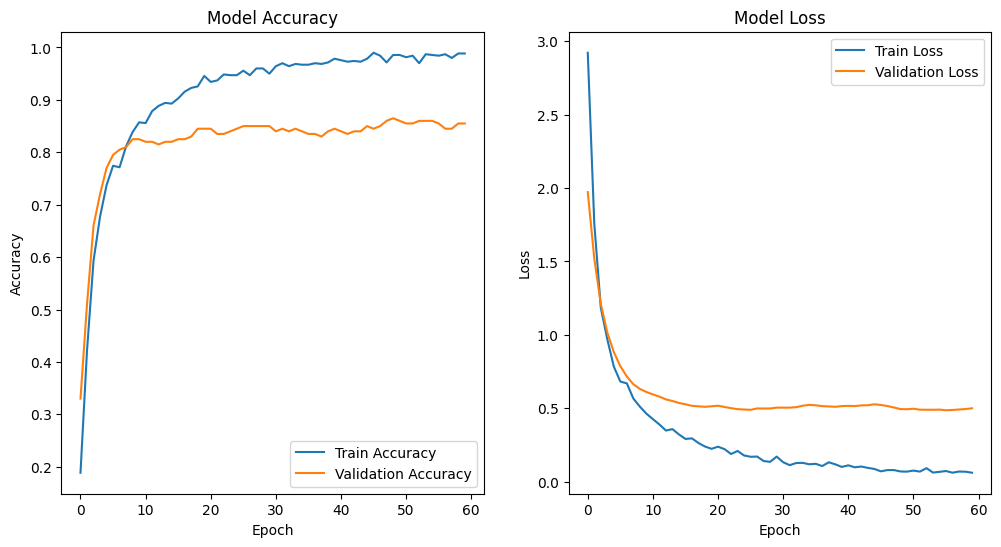

In [ ]:
def plot_metrics(history_NASNetMobile):

    plt.figure(figsize=(12, 6))


    plt.subplot(1, 2, 1)
    plt.plot(history_NASNetMobile.history['accuracy'], label='Train Accuracy')
    plt.plot(history_NASNetMobile.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_NASNetMobile.history['loss'], label='Train Loss')
    plt.plot(history_NASNetMobile.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()


    plt.show()


plot_metrics(history_NASNetMobile)

## Classification Report NASNetMobile

In [ ]:
class_names = list(val_gen.class_indices.keys())

y_test = []
y_pred = []
model_names = model_NASNetMobile
for i in range(len(test_gen)):
    x_batch, y_batch = test_gen.next()

    for j in range(len(y_batch)):

        y_test.append(class_names[tf.argmax(y_batch[j]).numpy()])

        prediction = model_names.predict(x_batch[j][None, ...], verbose=0)
        y_pred.append(class_names[np.argmax(prediction)])


print(classification_report(y_test, y_pred, target_names=class_names))

                   precision    recall  f1-score   support

Batik Cendrawasih       0.86      0.57      0.69        21
      Batik Dayak       0.62      0.75      0.68        20
 Batik Ikat Celup       0.67      0.75      0.71        16
     Batik Insang       1.00      0.75      0.86        20
     Batik Kawung       0.75      0.90      0.82        20
Batik Megamendung       1.00      0.81      0.89        21
     Batik Parang       1.00      0.90      0.95        21
     Batik Poleng       0.80      1.00      0.89        24
Batik Sekar Jagad       0.47      0.57      0.52        14
     Batik Tambal       0.77      0.74      0.76        23

         accuracy                           0.79       200
        macro avg       0.79      0.77      0.78       200
     weighted avg       0.81      0.79      0.79       200



## Classification Report Best Model NASNetMobile

In [ ]:
model_NASNetMobile_BEST = load_model('/content/BatikMotifMin_10_model_NASNetMobile_epoch_49.h5')

In [ ]:
class_names = list(val_gen.class_indices.keys())

y_test = []
y_pred = []
model_names = model_NASNetMobile_BEST
for i in range(len(test_gen)):
    x_batch, y_batch = test_gen.next()

    for j in range(len(y_batch)):

        y_test.append(class_names[tf.argmax(y_batch[j]).numpy()])

        prediction = model_names.predict(x_batch[j][None, ...], verbose=0)
        y_pred.append(class_names[np.argmax(prediction)])


print(classification_report(y_test, y_pred, target_names=class_names))

                   precision    recall  f1-score   support

Batik Cendrawasih       0.94      0.83      0.88        18
      Batik Dayak       0.62      0.80      0.70        20
 Batik Ikat Celup       0.69      0.82      0.75        22
     Batik Insang       1.00      0.67      0.80        21
     Batik Kawung       0.77      0.94      0.85        18
Batik Megamendung       1.00      0.83      0.91        18
     Batik Parang       0.90      0.76      0.83        25
     Batik Poleng       0.78      0.95      0.86        22
Batik Sekar Jagad       0.67      0.56      0.61        18
     Batik Tambal       0.72      0.72      0.72        18

         accuracy                           0.79       200
        macro avg       0.81      0.79      0.79       200
     weighted avg       0.81      0.79      0.79       200

